In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from scipy.stats import norm
from scipy.interpolate import make_interp_spline


from tqdm import tqdm

In [3]:
### Functions for solving the LASSO system of equations following Bean (2012)

##### Function G defined in Bean (2012)
def G(x,numSamps = 1000000):
    Z = np.random.normal(size=numSamps)
    diff = np.abs(Z) - x
    diff[diff < 0] = 0
    
    return np.mean(diff**2)
    
#### Main equation that we need to find a root of
def mainEQ(sigma_sq_eps,m2,m4,tau,c,v,beta_norm_sq,eta,K,phi_inv_v):
    return (m4*beta_norm_sq - tau**2/(phi_inv_v**2)
            + (tau**2)*(eta**2)/(gamma*K**2)+sigma_sq_eps*m2)

#### Definition of a number of intermediate quantities used in the main equation
def setIntermediates(c,gamma,lambs,eta,tau,sigma_sq_eps):
    v = 1-np.mean(1/(1+c*lambs**2))
    K = tau*c/v
    if 1-v/(2*gamma) >= 0:
        phi_inv_v = norm.ppf(1-v/(2*gamma))
        s = K/phi_inv_v
        beta_norm_sq = gamma*(s**2)*G(K/s) - 2*(eta**2)*v/gamma + eta**2
        m2 = np.mean(lambs**2/((1+c*lambs**2)**2))
        m4 = np.mean(lambs**4/((1+c*lambs**2)**2))
        
        return (v,K,phi_inv_v,s,beta_norm_sq,m2,m4)
    else:
        return [-1]

    

In [4]:
### Solve LASSO system of equations at the given parameters
def getLassoPredictions(gamma, eta, sigma_sq_eps, tau, numSamps = 1000000):
    lambs = np.random.uniform(size=numSamps)
    cs = np.linspace(0.01,2,1000)
    vals = np.array([0.0]*len(cs))
    count = 0
    for c in cs: ### brute force search over the parameter c
        intermediates = setIntermediates(c,gamma,lambs,eta,tau,sigma_sq_eps)
        if len(intermediates) > 1:
            (v,K,phi_inv_v,s,beta_norm_sq,m2,m4) = intermediates
            vals[count] = mainEQ(sigma_sq_eps,m2,m4,tau,c,v,beta_norm_sq,eta,K,phi_inv_v) 
        else:
            vals[count] = vals[count-1]
        count += 1

    ### Look for roots of the equation
    candidates = [] 
    for i in range(len(cs) - 1):
        if np.sign(vals[i])*np.sign(vals[i+1]) < 0:
            candidates = candidates + [cs[i]]

    print("------------------------Candidates----------------------------")
    print(candidates)

    ### Some roots cannot be a solution as they violate sign constraints for the parameters
    for c in candidates:
        (v,K,phi_inv_v,s,beta_norm_sq,m2,m4) = setIntermediates(c,gamma,lambs,eta,tau,sigma_sq_eps)
        if s > 0 and beta_norm_sq > 0:
            print("-------------------------True Solution-------------------")
            sol = (c, beta_norm_sq)

        print(c, s, beta_norm_sq, mainEQ(sigma_sq_eps,m2,m4,tau,c,v,beta_norm_sq,eta,K,phi_inv_v))
        
    return sol

def generateData(nTrain, nTest, d, eta, sigma_sq_eps, wZero=False):
    XTrain = np.diag(np.random.uniform(0,1,nTrain))@np.random.normal(size=(nTrain,d))
    XTest = np.diag(np.random.uniform(0,1,nTest))@np.random.normal(size=(nTest,d))
    
    if wZero:
        w = np.zeros(d)
    else:
        w = eta*np.random.normal(size=d)/(d**(1/2))
    
    YTrain = XTrain@w + np.sqrt(sigma_sq_eps)*np.random.normal(size=nTrain)
    YTest = XTest@w +  np.sqrt(sigma_sq_eps)*np.random.normal(size=nTest)
    

    return XTrain, YTrain, XTest, YTest

### Evaluate the empirical training-conditional coverage of the full conformal LASSO and it's uncorrected variant
### over one draw of the training set
def oneLassoExperiment(nTrain, nTest, d, eta, sigma_sq_eps, tau, alpha):
    XTrain, YTrain, XTest, YTest = generateData(nTrain, nTest, d, eta, sigma_sq_eps)
    
    ### run uncorrected method
    mod = Lasso(alpha=tau/np.sqrt(nTrain), fit_intercept=False)
    mod.fit(XTrain,YTrain)
    trainResid = np.abs(YTrain - mod.predict(XTrain))
    q = np.quantile(trainResid, 1-alpha)
    uncorrCov = np.mean(np.abs(YTest - mod.predict(XTest)) <= q)
    
    ### run full conformal
    corrCov = 0
    for i in range(nTest):
        XFull = np.row_stack((XTrain,XTest[i,:]))
        YFull = np.append(YTrain,YTest[i])
        
        
        mod = Lasso(alpha=tau/np.sqrt(nTrain), fit_intercept=False)
        mod.fit(XFull,YFull)
        resid = np.abs(YFull - mod.predict(XFull))
        q = np.quantile(resid, 1-alpha)
        corrCov = corrCov + (resid[-1] <= q)/nTest
        
    return(uncorrCov, corrCov)

### Given a solution to the LASSO system evaluate the true coverage of the uncorrected method
def estimateTrueCoverage(c, Ninf, sigma_sq_eps, alpha, numSamps = 1000000):
    Z = np.random.normal(size=numSamps)
    eps = np.sqrt(sigma_sq_eps)*np.random.normal(size=numSamps)
    lambs = np.random.uniform(0,1,numSamps)
    
    resids = np.abs(eps + lambs*Ninf*Z)
    
    return np.mean(resids <= np.quantile(resids/(1+c*lambs**2),1-alpha))

### Evaluate the l2 norm error of the estimated regression coefficients from the LASSO
def simulateNormError(n,d,sigma_sq_eps,tau,eta):
    X = np.random.normal(size=(n,d))
    lambs = np.random.uniform(size = n)
    X = np.diag(lambs)@X
    betastar = (eta/np.sqrt(d))*np.random.normal(size=d)
    eps = np.sqrt(sigma_sq_eps)*np.random.normal(size = n)
    Y = X@betastar + eps
    mod = Lasso(alpha=tau/np.sqrt(n), fit_intercept = False)
    mod.fit(X,Y)
    
    return sum((mod.coef_-betastar)**2)


In [8]:
### Empirically evaluate the training-conditional coverage of the full conformal LASSO and the uncorrected method 
### and compare this to the values predicted by the theory over various settings of the regularization and 
### dimension to sample size ratio. 

eta = 1
sigma_sq_eps = 1
taus = [0.25,0.5,1]

nTrials = 10000
nTest = 1
nTrain = 800
gammas = [0.1,0.2,0.3,0.4,0.5]
alpha = 0.1

nverify = 1000
numEquationSamps = 1000000

res = pd.DataFrame()
for gamma in gammas:
    for tau in taus:
        d = int(gamma*nTrain)
        dverify = int(gamma*nverify)
        ### Solve asymptotic system of equations
        sol = getLassoPredictions(gamma, eta, sigma_sq_eps, tau, numSamps = numEquationSamps)
        ### Compute resulting estimate of the coverage of the uncorrected method
        predCov = estimateTrueCoverage(sol[0], np.sqrt(sol[1]), sigma_sq_eps, alpha, numSamps = numEquationSamps)

        ### Compare l2 error predicted by the theory to an empirical draw
        simulatedNormError = simulateNormError(nverify,dverify,sigma_sq_eps,tau,eta)        
        print('----------Check------------')
        print(simulatedNormError, sol[1])

        ### Empirically evaluate the coverage
        for i in tqdm(range(nTrials)):
            (uncorrCov, corrCov) = oneLassoExperiment(nTrain, nTest, d, eta, sigma_sq_eps, tau, alpha)
            newRes = pd.DataFrame({
                'n' : [nTrain, nTrain],
                'gamma' : [gamma,gamma],
                'Dimension' : [d, d],
                'Method' : ['Uncorrected', 'Full Conformal'],
                'Coverage' : [uncorrCov, corrCov],
                'Predicted Coverage' : [predCov, 1-alpha],
                'tau' : [tau, tau]
            })
            res = pd.concat([res,newRes])



------------------------Candidates----------------------------
[0.2829029029029029, 0.4522222222222222]
-------------------------True Solution-------------------
0.2829029029029029 3.6174886586149344 0.25687346584678783 0.02994539979675523
0.4522222222222222 -3.81224329265451 0.7214690892732771 -0.021281830710375232
----------Check------------
0.28312453044306474 0.25687346584678783


100%|█████████████████████████████████████████| 10000/10000 [02:26<00:00, 68.31it/s]


------------------------Candidates----------------------------
[0.21716716716716716, 0.5438538538538539]
-------------------------True Solution-------------------
0.21716716716716716 3.6357727996785467 0.30924775739474764 0.028349268739121247
0.5438538538538539 -3.938060238643084 1.402620330186533 -0.010686345549643345
----------Check------------
0.3617818037092242 0.30924775739474764


100%|█████████████████████████████████████████| 10000/10000 [02:32<00:00, 65.49it/s]


------------------------Candidates----------------------------
[0.12354354354354354, 0.6852852852852852]
-------------------------True Solution-------------------
0.12354354354354354 3.6972555399658917 0.505573547545314 0.021687524533335667
0.6852852852852852 -4.508976279505373 4.474665419098386 -0.002651224820205106
----------Check------------
0.3932090369054639 0.505573547545314


100%|█████████████████████████████████████████| 10000/10000 [02:29<00:00, 66.81it/s]


------------------------Candidates----------------------------
[0.5896696696696696, 1.3346746746746745]
-------------------------True Solution-------------------
0.5896696696696696 2.9704649855551044 0.5256470585356645 0.004846622288360025
1.3346746746746745 -3.4848897255189795 2.624993270600036 -0.00036857015811567195
----------Check------------
0.48050052626091666 0.5256470585356645


100%|█████████████████████████████████████████| 10000/10000 [03:40<00:00, 45.25it/s]


------------------------Candidates----------------------------
[0.39445445445445443, 1.6932332332332332]
-------------------------True Solution-------------------
0.39445445445445443 2.9726535204072113 0.5165736675892333 0.0035499245558951176
1.6932332332332332 -4.406745269735915 7.558222835906113 -0.0005361884506670661
----------Check------------
0.5339841136064365 0.5165736675892333


100%|█████████████████████████████████████████| 10000/10000 [02:56<00:00, 56.80it/s]


------------------------Candidates----------------------------
[0.1813113113113113, 1.966136136136136]
-------------------------True Solution-------------------
0.1813113113113113 3.0312616297325112 0.677859975112216 -8.795591935606417e-05
1.966136136136136 -7.18385311331201 29.651322871342888 -0.0013909247189949486
----------Check------------
0.7504155595655047 0.677859975112216


100%|█████████████████████████████████████████| 10000/10000 [03:10<00:00, 52.59it/s]


------------------------Candidates----------------------------
[0.9283083083083082]
-------------------------True Solution-------------------
0.9283083083083082 2.761070589597453 0.7646319589569759 -3.247194982705648e-05
----------Check------------
0.7985328453350303 0.7646319589569759


100%|█████████████████████████████████████████| 10000/10000 [04:37<00:00, 35.99it/s]


------------------------Candidates----------------------------
[0.5558058058058057]
-------------------------True Solution-------------------
0.5558058058058057 2.7276792387536624 0.665593703503782 0.0015167221642098383
----------Check------------
0.5901820096398853 0.665593703503782


100%|█████████████████████████████████████████| 10000/10000 [05:02<00:00, 33.11it/s]


------------------------Candidates----------------------------
[0.22314314314314312]
-------------------------True Solution-------------------
0.22314314314314312 2.7612561677875576 0.76358838727362 0.0027030768218688217
----------Check------------
0.7237825153192063 0.76358838727362


100%|███████████████████████████████| 10000/10000 [04:44<00:00, 35.14it/s]


------------------------Candidates----------------------------
[1.2908508508508507]
-------------------------True Solution-------------------
1.2908508508508507 2.6660929797781345 0.9774133416302564 0.0007505997176394108
----------Check------------
0.8992761109154642 0.9774133416302564


100%|███████████████████████████████| 10000/10000 [05:50<00:00, 28.52it/s]


------------------------Candidates----------------------------
[0.7071971971971972]
-------------------------True Solution-------------------
0.7071971971971972 2.6092160870944823 0.7812444136086237 0.00041546895260749506
----------Check------------
0.755411181066281 0.7812444136086237


100%|███████████████████████████████| 10000/10000 [05:31<00:00, 30.18it/s]


------------------------Candidates----------------------------
[0.258998998998999]
-------------------------True Solution-------------------
0.258998998998999 2.622051121677427 0.8233958049249459 0.004128001535547016
----------Check------------
0.8196950844427684 0.8233958049249459


100%|███████████████████████████████| 10000/10000 [05:08<00:00, 32.40it/s]


------------------------Candidates----------------------------
[1.6733133133133131]
-------------------------True Solution-------------------
1.6733133133133131 2.628768631772991 1.1612252271618462 0.0003919432180733984
----------Check------------
1.0915124478704135 1.1612252271618462


100%|███████████████████████████████| 10000/10000 [06:17<00:00, 26.47it/s]


------------------------Candidates----------------------------
[0.8486286286286285]
-------------------------True Solution-------------------
0.8486286286286285 2.538503333547393 0.876275875612291 0.0009694616766624253
----------Check------------
0.9263734304372668 0.876275875612291


100%|███████████████████████████████| 10000/10000 [05:43<00:00, 29.12it/s]


------------------------Candidates----------------------------
[0.29286286286286284]
-------------------------True Solution-------------------
0.29286286286286284 2.5384898172604022 0.8623738183172185 0.0026333970018279085
----------Check------------
0.8494422271187259 0.8623738183172185


100%|███████████████████████████████| 10000/10000 [05:56<00:00, 28.02it/s]


In [10]:
### Empirically evaluate the distribution of the training-conditional coverage as the sample size increases

nTest = 2000
nTrains = [100, 200, 400, 800]
nTrials = 100
alpha = 0.1
gamma = 0.25
tau = 0.5

resCoverageConvergence = pd.DataFrame()
for nTrain in nTrains:
    d = math.floor(gamma*nTrain)
    for i in tqdm(range(nTrials)):
        uncorrCov, corrCov = oneLassoExperiment(nTrain, nTest, d, eta, sigma_sq_eps, tau, alpha)
        newRes = pd.DataFrame({
            'Number of Training Points' : [nTrain, nTrain],
            'Dimension' : [d, d],
            'Method' : ['Uncorrected', 'Full Conformal'],
            'Coverage' : [uncorrCov, corrCov]
        })
        resCoverageConvergence = pd.concat([resCoverageConvergence,newRes])


100%|███████████████████████████████████| 100/100 [11:13<00:00,  6.73s/it]


/var/folders/03/1mcjgjk12rv51t4kkk97lq5r0000gn/T/ipykernel_36781/1756588984.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resSub['tau'] = (2*resSub['tau']).astype('str')


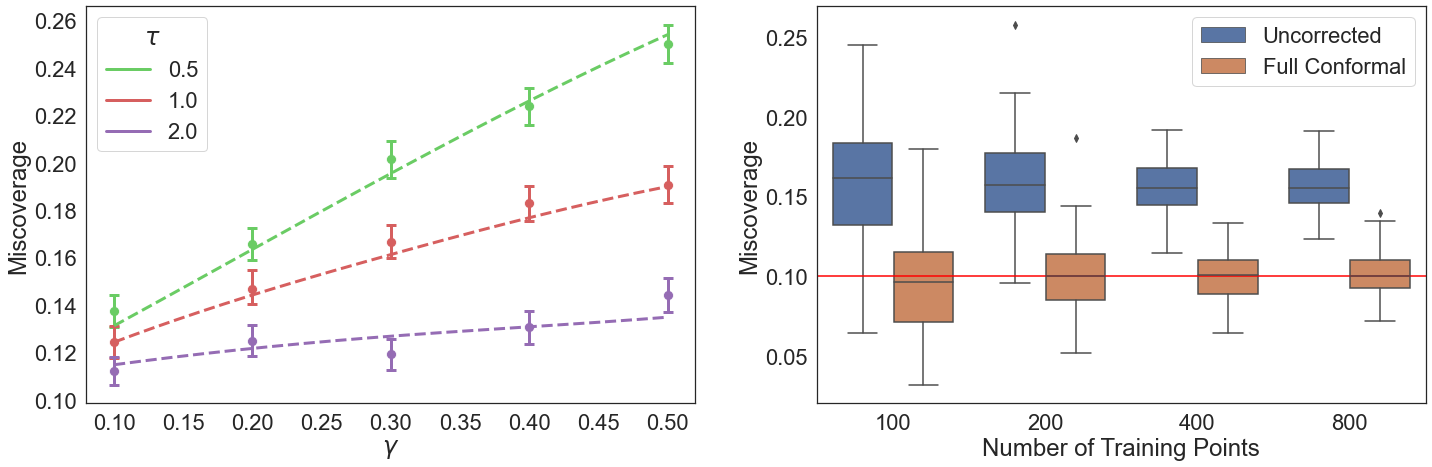

In [14]:
sns.set(rc={'figure.figsize':(24,7.3)})
sns.set(font_scale=2)
sns.set_style(style='white')
fig = plt.figure()

res['Miscoverage'] = 1 - res['Coverage']
resSub = res[res['Method'] == 'Uncorrected']
resSub['tau'] = (2*resSub['tau']).astype('str') ### Multiply by 2 to make this definition of tau match the one in the paper
gammas = np.array(gammas)

cmap = {}
count = 0
for tau in resSub['tau'].unique():
    cmap[tau] = sns.color_palette("muted")[:][2+count]
    count += 1

### Plot coverage predictions vs. empirically realized values
ax1 = fig.add_subplot(1,2,1)

##### Plot empirically realized values
f1 = sns.lineplot(
    data=resSub,
    x='gamma',
    y='Miscoverage',
    hue='tau',
    marker='o',
    linestyle='',
    err_style='bars',
    errorbar=('ci', 95),
    markersize=10,
    palette = cmap,
    ax = ax1,
    err_kws={"capsize": 5, "elinewidth": 3, "capthick": 3}
)

##### Plot coverage predictions
count = 0
for tau in resSub['tau'].unique():
    g_smooth = np.linspace(gammas.min(), gammas.max(), 300)
    preds = [np.mean(resSub['Predicted Coverage'][(resSub['tau'] == tau) & (resSub['gamma'] == gamma)]) for gamma in gammas]
    spline = make_interp_spline(gammas, preds, k=3)  
    y_smooth = spline(g_smooth)
    f1.plot(g_smooth,1-y_smooth,color=sns.color_palette("muted")[:][2+count],linewidth=3, linestyle='dashed')
    count += 1



plt.xlabel('$\\gamma$')
legend = plt.legend(loc='upper left', title = '$\\tau$')
legend.get_lines()[0].set_linewidth(3)
legend.get_lines()[1].set_linewidth(3)
legend.get_lines()[2].set_linewidth(3)

### Plot empirical coverage distribution as sample size increases

resCoverageConvergence['Miscoverage'] = 1-resCoverageConvergence['Coverage']

ax2 = fig.add_subplot(1,2,2)
f2 = sns.boxplot(resCoverageConvergence,x='Number of Training Points',y='Miscoverage',hue='Method')
f2.axhline(alpha, color='red')
#plt.legend(title='$\\tau=1, \\gamma=0.25$')
plt.legend(loc='upper right')


plt.savefig('figures/LASSO_Validation.pdf')